In [1]:
import pickle

import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import beta
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata, kendalltau, spearmanr

import plotly.graph_objects as go
from tqdm.notebook import tqdm
from pathlib import Path

sns.set_theme("paper", "white")

In [2]:
df_users = pd.read_csv("./DSock/Active_Users.csv", index_col=0)
display(df_users.head())

timeline = pd.date_range("2020-09-03-03:59:59", periods=6, tz="utc")

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
1,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,2.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,NaN
2,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,4.0,1.0,NaN
3,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,NaN
4,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN
5,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,4.0,3.0,NaN


In [3]:
topics = list("abcdefgh")
nums = list(range(9))
num2topic = dict(zip(nums, topics))
topic2num = dict(zip(topics, nums))
print(f"{topic2num} {num2topic}")
deltas = ["10", "21", "32", "43", "54"]

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7} {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}


In [4]:
df_evals = pd.read_csv("./DSock/human_eval_analysis/attitude_tracking.csv")
df_evals = pd.merge(df_users, df_evals, how="left", left_on="MTurk_ID", right_on="id").rename({"id_x": "id"}, axis=1)
df_evals.index = [f"u{u}" for u in df_evals["id"]]

display(df_evals.head())

get_change = lambda u, t: df_evals.loc[u][[f"{t}_delta_{d}" for d in deltas]].tolist()
print(get_change("u2337", num2topic[0]))

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,g_delta_10,g_delta_21,g_delta_32,g_delta_43,g_delta_54,h_delta_10,h_delta_21,h_delta_32,h_delta_43,h_delta_54
u2658,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
u2297,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2601,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2338,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2638,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[3.0, 0.0, 0.0, 0.0, 0.0]


In [5]:
df_posts = pd.read_csv("./DSock/direct_influence/posts_with_senti_and_topic.csv", parse_dates=["createdAt"])
df_comts = pd.read_csv("./DSock/direct_influence/comments_with_senti_and_topic.csv", delimiter=",", parse_dates=["createdAt"]).dropna(subset=["CommenterId", "PostId"])
df_views = pd.read_csv("./DSock/postViews.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_likes = pd.read_csv("./DSock/Likes.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_repts = pd.read_csv("./DSock/ReportUsers.csv", delimiter="|", parse_dates=["createdAt"])

print(f"posts: {df_posts.shape}, comments: {df_comts.shape}, views: {df_views.shape}, likes: {df_likes.shape}, reports: {df_repts.shape}")

df_likes["UserId"] = df_likes["UserId"].astype(int)
df_likes["PostId"] = df_likes["PostId"].astype(int)

df_comts["CommenterId"] = df_comts["CommenterId"].astype(int)
df_comts["PostId"] = df_comts["PostId"].astype(int)

df_annot_posts = pd.read_csv("./DSock/posts_anno_labels.csv")
df_posts = df_posts.merge(df_annot_posts[["post_id", "majority_topic_label", "majority_sent_label"]], left_on="PostID", right_on="post_id")

df_annot_comts = pd.read_csv("./DSock/comments_anno_labels.csv")
df_comts = df_comts.merge(df_annot_comts[["comment_id", "majority_topic_label", "majority_sent_label"]], left_on="id", right_on="comment_id")

posts: (1057, 11), comments: (1615, 11), views: (234178, 10), likes: (1034, 6), reports: (46, 6)


In [6]:
post_comments = {f"p{p}": [] for p in df_posts["PostID"].values}
for c, p in df_comts[["id", "PostId"]].values:
    if f"p{p}" in post_comments:
        post_comments[f"p{p}"].append(f"c{c}")
G = nx.DiGraph()
for u, uname, obsr, sock in df_users[["id", "username", "isObserver", "isPuppet"]].values:
    G.add_node(f"u{u}", id=u, kind="user", name=uname, observer=(obsr == "t"), sock=(sock == "t"))
    if obsr == "t":
        G.nodes[f"u{u}"]["color"] = "obsr"
    elif sock == "t":
        G.nodes[f"u{u}"]["color"] = "sock"
    else:
        G.nodes[f"u{u}"]["color"] = "part"

for p, u, t, polar, score, topic in df_posts[["PostID", "AuthorId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes:
        G.add_node(f"p{p}", id=p, kind="post", time=t, user=u, polar=polar, score=score, topic=topic)

for c, u, p, t, polar, score, topic in df_comts[["id", "CommenterId", "PostId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"c{c}", id=c, kind="comt", time=t, user=u, polar=polar, score=score, topic=topic)
        G.add_edge(f"c{c}", f"p{p}", kind="known", time=t, weight=1)
        # G.add_edge(f"p{p}", f"c{c}", kind="known", time=t, weight=1)

for l, u, p, t in df_likes[["id", "UserId", "PostId", "createdAt"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"l{l}", user=f"u{u}", post=f"p{p}", time=t, id=l, kind="like",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"l{l}", time=t, weight=1, kind="infer")
        G.add_edge(f"l{l}", f"p{p}", time=t, weight=1, kind="known")

for u, p, t, v, s in df_views[["UserId", "PostId", "createdAt", "id", "singleView"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"v{v}", user=f"u{u}", post=f"p{p}", time=t, id=v, kind="view",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"v{v}", time=t, weight=1, kind="infer")
        G.add_edge(f"v{v}", f"p{p}", time=t, weight=1, kind="infer")
        if s == "t":
            for c in post_comments[f"p{p}"]:
                if c in G.nodes:
                    G.add_edge(f"v{v}", c, time=t, weight=1, kind="infer")
user_view = {u: set() for u in G if u[0] == "u"}
for u, p, t, v, s in df_views[["UserId", "PostId", "createdAt", "id", "singleView"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes and s != "t":
        user_view[f"u{u}"].add(f"v{v}")

single_view = {u: set() for u in G if u[0] == "u"}
for u, p, t, v, s in df_views[["UserId", "PostId", "createdAt", "id", "singleView"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes and s == "t":
        single_view[f"u{u}"].add(f"v{v}")

print(f"user view: {sum([len(user_view[u]) for u in user_view])}")
print(f"single view: {sum([len(single_view[u]) for u in single_view])}")

for p in tqdm(G):
    if p[0] in ["p", "c"]:
        u = f"u{G.nodes[p]['user']}"
        for v in user_view[u] | single_view[u]:
            if G.nodes[v]["time"] <= G.nodes[p]["time"]:
                G.add_edge(p, v, time=G.nodes[v]["time"], weight=1, kind="infer")

user view: 210543
single view: 3808


In [7]:
with open("res/pagerank/0.85-0.5-0.5.pkl", "rb") as fp:
    d = pickle.load(fp)

In [8]:
df_users[df_users["id"] == 2340]

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
7,A1CGW3DQ5JRSJH,Asia_3576,2340,f,t,f,0,0,0,0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN


In [9]:
user_list = df_users["id"].tolist()
# user_list = df_users[df_users["isObserver"] == "f"]["id"].tolist()

In [10]:
obsr_list = [f"u{u}" for u in df_users[df_users["isObserver"] == "t"]["id"]]
pr_alpha = 0.85
beta_a = 0.5
beta_b = 0.5
keyq = [(node_name, t, topic, polar, pr_alpha, beta_a, beta_b)
        for node_name in obsr_list for t in range(1,6) for topic in range(8) for polar in [0, 2]
       ]

keyq = list(filter(lambda x: get_change(x[0], num2topic[x[2]])[x[1]-1]*(1-x[3]) > 0, tqdm(keyq)))

In [11]:
property_full = {k: d[k]["full_graph"] for k in tqdm(keyq)}
property_exps = {k: d[k]["exps_graph"] for k in tqdm(keyq)}

df_full = pd.DataFrame.from_dict(property_full, orient="index")
df_exps = pd.DataFrame.from_dict(property_exps, orient="index")

In [12]:
use_color = sns.color_palette("Set1")
use_color

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [13]:
pd.DataFrame.from_dict({
    ("Full Influence Graph", "mean"): df_full.mean(axis=0),
    ("Full Influence Graph", "std"): df_full.std(axis=0),
    ("Expression only Influence Graph", "mean"): df_exps.mean(axis=0),
    ("Expression only Influence Graph", "std"): df_exps.std(axis=0),
}).T

nodes        edges  components  \
Full Influence Graph            mean   462.183099  1476.161972    1.000000   
                                std   1225.934304  4455.952356    0.000000   
Expression only Influence Graph mean    14.711268     5.619718    9.091549   
                                std     26.742158    12.095209   15.051168   

                                       density  diameter    degree  
Full Influence Graph            mean  0.023673  3.021127  1.305359  
                                std   0.059780  2.980952  1.273526  
Expression only Influence Graph mean  0.008994  0.000000  0.149261  
                                std   0.018341  0.000000  0.208950

In [70]:
pab = [(p, a, b)
    for p in [0.85, 0.9, 0.7, 0.5, 0.3, 0.1]
    for a in [0.5, 1.0, 1.5, 2.0]
    for b in [0.5, 1.0, 1.5, 2.0]
    # for a in [0.5, 0.9, 0.7, 0.3, 0.1]
    # for b in [0.5, 0.9, 0.7, 0.3, 0.1]
]
obsr_list = [f"u{u}" for u in df_users[df_users["isObserver"] == "t"]["id"]]

In [71]:
def pr2rank(pr_value):
    ret = {u: 0 for u in user_list}
    for n in pr_value:
        if n[0] in ["p", "c"]:
            ret[G.nodes[n]["user"]] += pr_value[n]
    rank_value = [-ret[u] for u in user_list]
    rank = rankdata(rank_value, "max")
    # rank = [r if r < max(rank) else np.nan for r in rank]
    # print(rankdata(rank, "min"))
    return dict(zip(user_list, rank))

def get_params(p, a, b):
    fpath = Path(f"res/pagerank/{p}-{a}-{b}.pkl")
    if not fpath.exists():
        return None
    with open(fpath, "rb") as fp:
        d = pickle.load(fp)
    keyq = [(node_name, t, topic, polar, p, a, b)
            for node_name in obsr_list for t in range(1, 6) for topic in range(8) for polar in [0, 2]
            ]
    keyq = list(filter(lambda x: get_change(x[0], num2topic[x[2]])[x[1]-1]*(1-x[3]) > 0, keyq))
    ranks = [(k, pr2rank(d[k]["pr"])) for k in keyq]
    return ranks

ret = [get_params(*tup) for tup in tqdm(pab)]

In [72]:
keys = [x[0] for r in ret if r is not None for x in r]
values = [x[1] for r in ret if r is not None for x in r]
rank_dict = dict(zip(keys, values))

df_inf = pd.DataFrame.from_dict(rank_dict, orient="index")
display(df_inf.head())

2658  2297  2601  2338  2638  2701  2340  2719  \
u2297 3 4 2 0.85 0.5 0.5   116   116   116   116   116   116   116   116   
      4 3 0 0.85 0.5 0.5   116   116   116   116   116   116   116   116   
        4 0 0.85 0.5 0.5   116   116   116   116   116   116   116   116   
      5 3 2 0.85 0.5 0.5   116   116   116   116     6   116   116   116   
u2338 1 6 0 0.85 0.5 0.5   116   116   116   116   116   116   116   116   

                          2667  2342  ...  2636  2734  2657  2441  2714  2313  \
u2297 3 4 2 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   
      4 3 0 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   
        4 0 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   
      5 3 2 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   
u2338 1 6 0 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   

                          2337  2350  2703  2749  
u2297 3 4 2 0.85 0.5 0.5   116   116   116   116  
      4 3 0 0.85 0.5 0.5   116   116   116   116  
        4 0 0.85 0.5 0.5   116   116   116   116  
      5 3 2 0.85 0.5 0.5   116   116   116   116  
u2338 1 6 0 0.85 0.5 0.5   116   116   116   116  

[5 rows x 116 columns]

In [73]:
avg_inf = df_inf.mean(axis=0, level=[1, 4, 5, 6])
display(avg_inf.head(10))

,,,,2658,2297,2601,2338,2638,2701,2340,2719,2667,2342,...,2636,2734,2657,2441,2714,2313,2337,2350,2703,2749
3,0.85,0.5,0.5,111.928571,116.0,108.821429,116.0,108.071429,101.214286,116.0,108.214286,104.714286,116.0,...,116.000000,108.857143,103.678571,116.000000,112.357143,116.0,116.0,116.0,109.571429,116.0
4,0.85,0.5,0.5,106.750000,116.0,90.958333,116.0,106.916667,89.375000,116.0,97.916667,85.833333,116.0,...,116.000000,99.500000,101.625000,106.666667,107.500000,116.0,116.0,116.0,105.458333,116.0
5,0.85,0.5,0.5,91.411765,116.0,98.647059,116.0,96.764706,97.176471,116.0,103.764706,91.176471,116.0,...,116.000000,103.882353,109.235294,102.823529,116.000000,116.0,116.0,116.0,103.823529,116.0
1,0.85,0.5,0.5,116.000000,116.0,116.000000,116.0,112.904110,114.493151,116.0,105.191781,112.904110,116.0,...,114.479452,110.575342,100.246575,116.000000,116.000000,116.0,116.0,116.0,114.520548,116.0
3,0.85,0.5,1.0,111.928571,116.0,108.750000,116.0,108.071429,101.071429,116.0,108.214286,105.000000,116.0,...,116.000000,109.000000,103.678571,116.000000,112.357143,116.0,116.0,116.0,109.714286,116.0
4,0.85,0.5,1.0,106.750000,116.0,91.000000,116.0,106.916667,89.375000,116.0,97.916667,86.291667,116.0,...,116.000000,99.833333,101.625000,106.666667,107.500000,116.0,116.0,116.0,105.958333,116.0
5,0.85,0.5,1.0,91.352941,116.0,98.705882,116.0,96.764706,97.294118,116.0,103.764706,91.176471,116.0,...,116.000000,104.000000,109.235294,102.823529,116.000000,116.0,116.0,116.0,103.882353,116.0
1,0.85,0.5,1.0,116.000000,116.0,116.000000,116.0,112.904110,114.534247,116.0,105.178082,112.904110,116.0,...,114.479452,110.575342,100.246575,116.000000,116.000000,116.0,116.0,116.0,114.561644,116.0
3,0.85,0.5,1.5,111.928571,116.0,108.750000,116.0,108.071429,101.071429,116.0,108.214286,105.071429,116.0,...,116.000000,109.071429,103.678571,116.000000,112.357143,116.0,116.0,116.0,109.714286,116.0
4,0.85,0.5,1.5,106.750000,116.0,90.833333,116.0,106.916667,89.375000,116.0,97.916667,86.750000,116.0,...,116.000000,99.833333,101.625000,106.666667,107.500000,116.0,116.0,116.0,106.041667,116.0


In [74]:
pab_done = set([k[4:] for k in keys])
pab_done = [tup for tup in pab if tup in pab_done]

In [75]:
df_user_express = pd.read_csv("./DSock/User_Expressed_Influence_Rank.csv")
display(df_user_express.head())

df_active_user_express = pd.read_csv("./DSock/Active_User_Expressed_Influence_Rank.csv")
display(df_active_user_express.head())

,MTurk_ID,username,id,Role,survey,mentions,per_rank
0,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,1,0,0.0
1,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,2,0,0.0
2,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,3,0,0.0
3,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,4,0,0.0
4,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,5,0,0.0


,MTurk_ID,username,id,Role,survey,mentions
0,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,1,0
1,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,2,0
2,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,3,0
3,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,4,0
4,AKK6H2YXK4RF6,Allison_2019,2627,participant,1,5


In [76]:
df_active_user_express.loc[df_active_user_express["mentions"].nlargest(5).index]

,MTurk_ID,username,id,Role,survey,mentions
79,A3191G66DZEGEB,Cody_5364,2711,participant,3,9
64,A3C8JI69WPTKWH,Carly_8867,2702,participant,5,7
78,A3191G66DZEGEB,Cody_5364,2711,participant,2,7
162,AK1PBMID4RD59,Heather_253,2687,participant,5,7
204,A10IUXCZBNYUXC,Jacob_1907,2658,participant,2,7


In [77]:
def jaccard(col1, col2, num=10):
    r1 = set(col1.nsmallest(num).index)
    r2 = set(col2.nsmallest(num).index)
    ret = len(r1&r2)/len(r1|r2) if len(r1|r2) > 0 else np.nan
    return ret

def topkprecision(col1, col2, num=10):
    r1 = set(col1.nsmallest(num).index)
    r2 = set(col2.nsmallest(num).index)
    ret = len(r1&r2)/len(r1) if len(r1) > 0 else np.nan
    return ret

def rank_metrics(col1, col2):
    ret1 = {
        "spearman": dict(zip(["correlation", "pvalue"], spearmanr(col1, col2))),
        "kendaltau": dict(zip(["correlation", "pvalue"], kendalltau(col1, col2))),
    }
    
    ret2 = {
        f"jaccard-{j}": {"correlation": jaccard(col1, col2, j), "pvalue": None}
        for j in [10, 20, 30, 40, 50, 60, 69]
    }
    
    ret3 = {
        f"precision-{j}": {"correlation": topkprecision(col1, col2, j), "pvalue": None}
        for j in [10, 20, 30, 40, 50, 60, 69]
    }
    
    return {**ret1, **ret2, **ret3}

# print(jaccard(df_user_express["per_rank"], df_cor[(0.85, 0.5,0.5)].rank(ascending=False, pct=True, method="max")))
# print(rank_metrics(-df_user_express["per_rank"], df_cor[(0.85, 0.5, 0.5)]))

In [78]:
# pd.set_option('precision', 3)

In [79]:
df_cor = {tup: [avg_inf.loc[(t, *tup), n] if (t, *tup) in avg_inf.index else None for n, t in df_active_user_express[["id", "survey"]].values] for tup in tqdm(pab_done)}

df_cor = pd.DataFrame.from_dict(df_cor)
df_cor = pd.concat([df_cor, df_active_user_express], axis=1).dropna(axis=0)

df_cor = df_cor[df_cor["mentions"] > 0]

res_all = {tup: rank_metrics(
    df_cor["mentions"].rank(ascending=False, pct=True, method="dense"),
    df_cor[tup].rank(ascending=True, pct=True, method="dense"))
           for tup in tqdm(pab_done)}
df_res = pd.concat([pd.DataFrame(res_all[tup]) for tup in tqdm(pab_done)], keys=pab_done)
print(df_res.loc[(slice(None), slice(None), slice(None), "correlation")].max())
display(df_res)

idxmax = df_res.loc[(slice(None), slice(None), slice(None), "correlation")].idxmax()
print(idxmax)

display(pd.concat([df_res.loc[(*ind, slice(None)), :] for ind in set(idxmax)], axis=0))


spearman        0.261477
kendaltau       0.195092
jaccard-10      0.111111
jaccard-20      0.212121
jaccard-30      0.428571
jaccard-40      0.481481
jaccard-50      0.666667
jaccard-60      0.818182
jaccard-69      1.000000
precision-10    0.200000
precision-20    0.350000
precision-30    0.600000
precision-40    0.650000
precision-50    0.800000
precision-60    0.900000
precision-69    1.000000
dtype: float64


spearman  kendaltau  jaccard-10  jaccard-20  \
0.85 0.5 0.5 correlation  0.260511   0.194133    0.111111    0.212121   
             pvalue       0.030625   0.032932         NaN         NaN   
         1.0 correlation  0.259350   0.192632    0.111111    0.212121   
             pvalue       0.031402   0.034310         NaN         NaN   
         1.5 correlation  0.255016   0.189630    0.111111    0.212121   
...                            ...        ...         ...         ...   
0.30 2.0 1.5 pvalue       0.031744   0.033845         NaN         NaN   
         2.0 correlation  0.259967   0.194091    0.111111    0.212121   
             pvalue       0.030987   0.032934         NaN         NaN   
0.10 0.5 0.5 correlation  0.256738   0.191632    0.111111    0.212121   
             pvalue       0.033213   0.035255         NaN         NaN   

                          jaccard-30  jaccard-40  jaccard-50  jaccard-60  \
0.85 0.5 0.5 correlation    0.428571    0.481481    0.666667    0.818182   
             pvalue              NaN         NaN         NaN         NaN   
         1.0 correlation    0.428571    0.481481    0.666667    0.818182   
             pvalue              NaN         NaN         NaN         NaN   
         1.5 correlation    0.428571    0.481481    0.666667    0.818182   
...                              ...         ...         ...         ...   
0.30 2.0 1.5 pvalue              NaN         NaN         NaN         NaN   
         2.0 correlation    0.428571    0.481481    0.666667    0.818182   
             pvalue              NaN         NaN         NaN         NaN   
0.10 0.5 0.5 correlation    0.428571    0.454545    0.666667    0.818182   
             pvalue              NaN         NaN         NaN         NaN   

                          jaccard-69  precision-10  precision-20  \
0.85 0.5 0.5 correlation         1.0           0.2          0.35   
             pvalue              NaN           NaN           NaN   
         1.0 correlation         1.0           0.2          0.35   
             pvalue              NaN           NaN           NaN   
         1.5 correlation         1.0           0.2          0.35   
...                              ...           ...           ...   
0.30 2.0 1.5 pvalue              NaN           NaN           NaN   
         2.0 correlation         1.0           0.2          0.35   
             pvalue              NaN           NaN           NaN   
0.10 0.5 0.5 correlation         1.0           0.2          0.35   
             pvalue              NaN           NaN           NaN   

                          precision-30  precision-40  precision-50  \
0.85 0.5 0.5 correlation           0.6         0.650           0.8   
             pvalue                NaN           NaN           NaN   
         1.0 correlation           0.6         0.650           0.8   
             pvalue                NaN           NaN           NaN   
         1.5 correlation           0.6         0.650           0.8   
...                                ...           ...           ...   
0.30 2.0 1.5 pvalue                NaN           NaN           NaN   
         2.0 correlation           0.6         0.650           0.8   
             pvalue                NaN           NaN           NaN   
0.10 0.5 0.5 correlation           0.6         0.625           0.8   
             pvalue                NaN           NaN           NaN   

                          precision-60  precision-69  
0.85 0.5 0.5 correlation           0.9           1.0  
             pvalue                NaN           NaN  
         1.0 correlation           0.9           1.0  
             pvalue                NaN           NaN  
         1.5 correlation           0.9           1.0  
...                                ...           ...  
0.30 2.0 1.5 pvalue                NaN           NaN  
         2.0 correlation           0.9           1.0  
             pvalue                NaN           NaN  
0.10 0.5 0.5 correlation    

spearman         (0.5, 0.5, 1.0)
kendaltau        (0.5, 0.5, 1.0)
jaccard-10      (0.85, 0.5, 0.5)
jaccard-20      (0.85, 0.5, 0.5)
jaccard-30      (0.85, 0.5, 0.5)
jaccard-40      (0.85, 0.5, 0.5)
jaccard-50      (0.85, 0.5, 0.5)
jaccard-60      (0.85, 0.5, 0.5)
jaccard-69      (0.85, 0.5, 0.5)
precision-10    (0.85, 0.5, 0.5)
precision-20    (0.85, 0.5, 0.5)
precision-30    (0.85, 0.5, 0.5)
precision-40    (0.85, 0.5, 0.5)
precision-50    (0.85, 0.5, 0.5)
precision-60    (0.85, 0.5, 0.5)
precision-69    (0.85, 0.5, 0.5)
dtype: object


spearman  kendaltau  jaccard-10  jaccard-20  \
0.50 0.5 1.0 correlation  0.261477   0.195092    0.111111    0.212121   
             pvalue       0.029990   0.032043         NaN         NaN   
0.85 0.5 0.5 correlation  0.260511   0.194133    0.111111    0.212121   
             pvalue       0.030625   0.032932         NaN         NaN   

                          jaccard-30  jaccard-40  jaccard-50  jaccard-60  \
0.50 0.5 1.0 correlation    0.428571    0.481481    0.666667    0.818182   
             pvalue              NaN         NaN         NaN         NaN   
0.85 0.5 0.5 correlation    0.428571    0.481481    0.666667    0.818182   
             pvalue              NaN         NaN         NaN         NaN   

                          jaccard-69  precision-10  precision-20  \
0.50 0.5 1.0 correlation         1.0           0.2          0.35   
             pvalue              NaN           NaN           NaN   
0.85 0.5 0.5 correlation         1.0           0.2          0.35   
             pvalue              NaN           NaN           NaN   

                          precision-30  precision-40  precision-50  \
0.50 0.5 1.0 correlation           0.6          0.65           0.8   
             pvalue                NaN           NaN           NaN   
0.85 0.5 0.5 correlation           0.6          0.65           0.8   
             pvalue                NaN           NaN           NaN   

                          precision-60  precision-69  
0.50 0.5 1.0 correlation           0.9           1.0  
             pvalue                NaN           NaN  
0.85 0.5 0.5 correlation           0.9           1.0  
             pvalue                NaN           NaN

Text(0.5, 0, 'PageRank: 0 means highest, 1 means lowest')

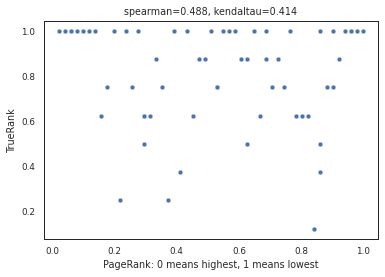

In [47]:
df_rank = pd.DataFrame.from_dict(
    {
        "FIGRank": df_cor[(0.5, 0.5, 0.5)].rank(ascending=False, pct=True, method="dense"),
        "TrueRank": df_cor["mentions"].rank(ascending=False, pct=True, method="dense"),
    }
)

ax = sns.scatterplot(data=df_rank, x="FIGRank", y="TrueRank")

ax.set_title("spearman=0.488, kendaltau=0.414")
ax.set_xlabel("PageRank: 0 means highest, 1 means lowest")